In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.environments import Env, Env_ActInf
from src.agents import AgentEWA, AgentQ
import src.helpers as F 

import pymdp
from pymdp import utils
from pymdp.agent import Agent as AgentActInf


sns.set_style('whitegrid')

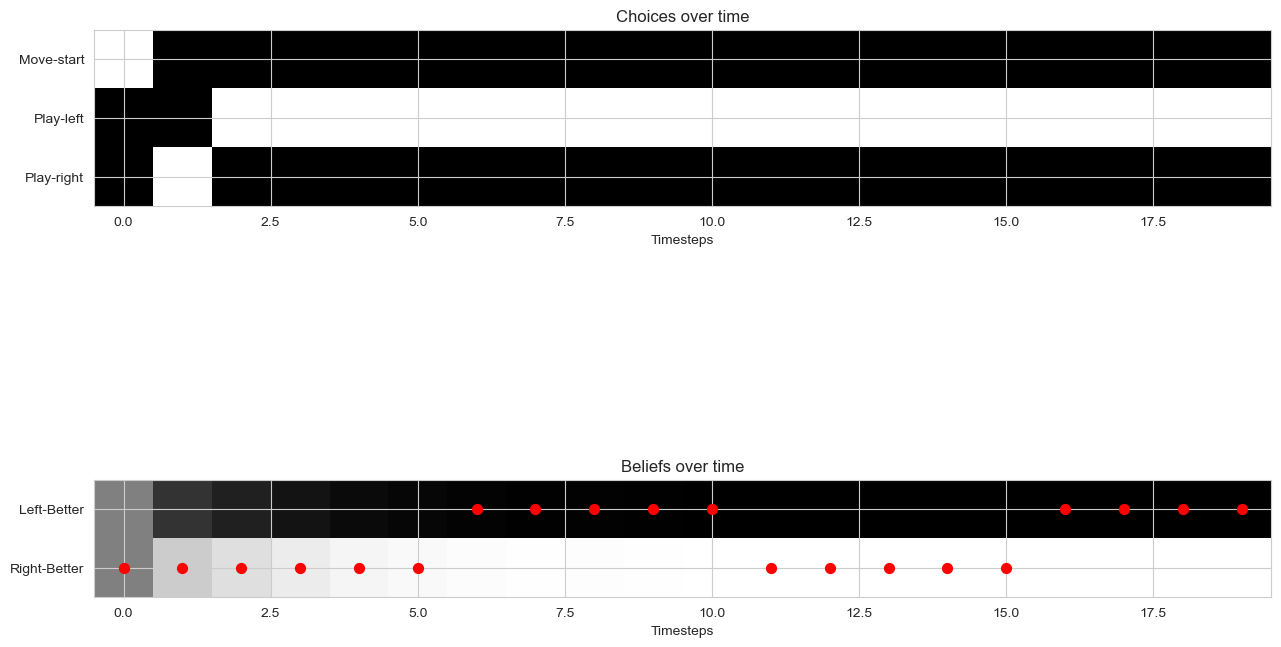

In [2]:
# actinf agent
EPISODES = 5
RUN_LENGTH = 20

switch_at = [5,10,15]

env_actinf = Env_ActInf(p_reward=0.7, context=1) # TODO


actinf_model = F.MDPGenerativeModel()
A, B, C, D = actinf_model.create_A(), actinf_model.create_B(), actinf_model.create_C(), actinf_model.create_D() # TODO pass the correct params
pA = F.parameterize_pA(A_base=A, scale = 1.0, prior_count=10e5)
agent_actinf = AgentActInf(A=A, pA=pA, B=B, C=C, D=D, modalities_to_learn=[1], lr_pA = 1.0, use_param_info_gain=True, action_selection='deterministic')

# agent_actinf.__dict__
returns_actinf = np.zeros([EPISODES, RUN_LENGTH])
choice_hist, belief_hist, qA_hist, context_hist = actinf_model.run_active_inference_with_learning(agent_actinf, env_actinf, T=RUN_LENGTH, t_change=switch_at)
F.plot_choices_beliefs(choice_hist, belief_hist, context_hist, choice_action_names=actinf_model.choice_action_names)

In [2]:
# env = Env(payoff_structure=(0.6, 0.3, 0.1))
high_low_var = (1, 0, 0)
env = Env(payoff_structure=high_low_var)
env_actinf = Env_ActInf(p_reward=0.7, context=env.best_action) # TODO

EPISODES = 2000
RUN_LENGTH = 1000

""" arrays to hold returns and Q values history"""
# Q agents
returns_Q, qvals_Q = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_Q_smart, qvals_Q_smart = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_Q_social, qvals_Q_social = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_Q_greedy, qvals_Q_greedy = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_Q_greedy_soc, qvals_Q_greedy_soc = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])

# EWA agents
returns_EWA, qvals_EWA = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_smart, qvals_EWA_smart = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_conform, qvals_EWA_conform = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_ind, qvals_EWA_ind = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_asoc, qvals_EWA_asoc = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])

# actinf agent - define generative model
actinf_model = F.MDPGenerativeModel()
A, B, C, D = actinf_model.create_A(), actinf_model.create_B(), actinf_model.create_C(), actinf_model.create_D() # TODO pass the correct params
returns_actinf = np.zeros([EPISODES, RUN_LENGTH])


""" simulation """

for episode in range(EPISODES):

    agentQ = AgentQ('Q default', is_social=False)
    agentQ_smart = AgentQ('Q smart', is_social=False)
    agentQ_social = AgentQ("Q social", is_social=True) # selects the most popular action
    agentQ_greedy = AgentQ("Q greedy", epsilon=0, is_social=False)

    agentEWA = AgentEWA('EWA default', is_social=True)
    agentEWA_smart = AgentEWA('EWA smart', is_social=True)
    agentEWA_conform = AgentEWA('EWA conformist', sigma=0.75, is_social=True)
    agentEWA_ind = AgentEWA('EWA individualist', sigma=0.25, is_social=True)
    agentEWA_asoc = AgentEWA('EWA asocial ', sigma=0, is_social=False)

    """
        >> add all agents to the list below
    """
    agent_list = [agentQ, agentQ_smart, agentQ_social, agentQ_greedy,
                  agentEWA, agentEWA_smart, agentEWA_conform, agentEWA_ind, agentEWA_asoc]



    agent_actinf = AgentActInf(A=A, B=B, C=C, D=D)
    # run actinf sim
    # actinf_model.run_active_inference_with_learning(agent_actinf, env_actinf, T=RUN_LENGTH)
    

    env.reset()

    for i in range(RUN_LENGTH):
        actions_this_round = {}
        actions_last_round =  None if (i == 0) else env.history[-1] # TODO?

        if i % 250 == 0:
            # switch reward probabilities, reset 'smart' agents 
            env.switch()
            agentQ_smart.reset_Qvals()
            agentEWA_smart.reset_Qvals()

        for agent in agent_list:
            choice = agent.choose_action(context=actions_last_round)
            actions_this_round[agent.id] = choice
            reward, is_optimal = env.return_rewards(choice)
            agent.update_state(reward, is_optimal)
            agent.update_Qvals(choice, reward)

        env.history.append(actions_this_round)
    

    # Store returns at the end of an episode
    returns_Q[episode, :] = agentQ.payoffs
    returns_Q_smart[episode, :] = agentQ_smart.payoffs
    returns_Q_social[episode, :] = agentQ_social.payoffs
    returns_Q_greedy[episode, :] = agentQ_greedy.payoffs
    
    returns_EWA[episode, :] = agentEWA.payoffs
    returns_EWA_smart[episode, :] = agentEWA_smart.payoffs
    returns_EWA_conform[episode, :] = agentEWA_conform.payoffs
    returns_EWA_ind[episode, :] = agentEWA_ind.payoffs
    returns_EWA_asoc[episode, :] = agentEWA_asoc.payoffs

    # Do the same for Q values
    qvals_Q[:, :, episode] = np.array(agentQ.Q_vals)
    qvals_Q_smart[:, :, episode] = np.array(agentQ_smart.Q_vals)
    qvals_Q_social[:, :, episode] = np.array(agentQ_social.Q_vals)
    qvals_Q_greedy[:, :, episode] = np.array(agentQ_greedy.Q_vals)
    
    qvals_EWA[:, :, episode] = np.array(agentEWA.Q_vals)
    qvals_EWA_smart[:, :, episode] = np.array(agentEWA.Q_vals)
    qvals_EWA_conform[:, :, episode] = np.array(agentEWA_conform.Q_vals)
    qvals_EWA_ind[:, :, episode] = np.array(agentEWA_ind.Q_vals)
    qvals_EWA_asoc[:, :, episode] = np.array(agentEWA_asoc.Q_vals)



In [20]:
mean[:,0]

array([0.1       , 0.14115   , 0.1859254 , ..., 0.1630359 , 0.16268907,
       0.16223287])

(0.0, 1.0)

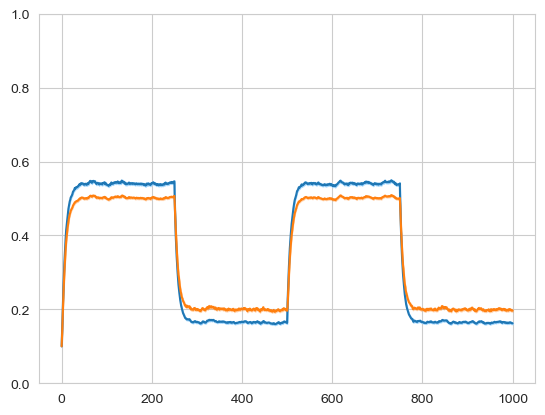

In [27]:
qvals = qvals_EWA

mean = np.mean(qvals, axis=2)
std_err = np.std(qvals, axis=2) / np.sqrt(qvals.shape[2])
fig, ax = plt.subplots()
ax.plot(mean)

ax.fill_between(range(mean.shape[0]), mean[:,0] + std_err[:,0], mean[:,0] - std_err[:,0], alpha=0.8, color='xkcd:light blue')
ax.fill_between(range(mean.shape[0]), mean[:,1] + std_err[:,1], mean[:,1] - std_err[:,1], alpha=0.3, color='C1')


plt.ylim(0,1)

In [3]:
returns_all =  (returns_Q, returns_Q_smart, returns_Q_social, returns_Q_greedy, 
                returns_EWA, returns_EWA_smart, returns_EWA_conform, returns_EWA_ind, returns_EWA_asoc)

for ret in returns_all:
    print(np.mean(ret))

0.5001665
0.749167
0.5421805
0.5
0.538515
0.5391675
0.5541015
0.523476
0.508288


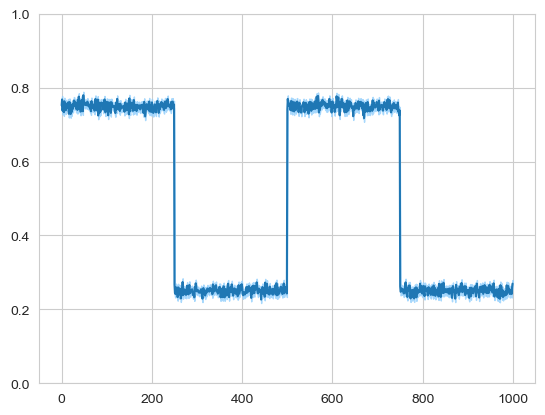

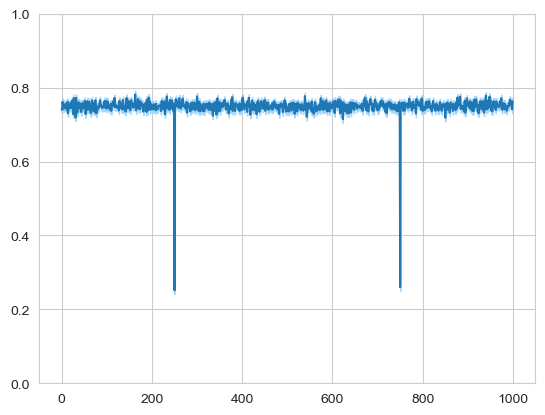

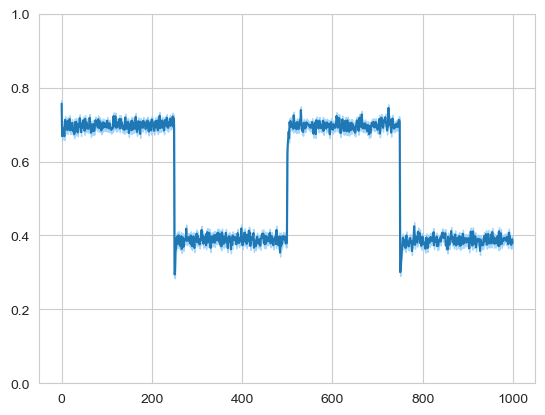

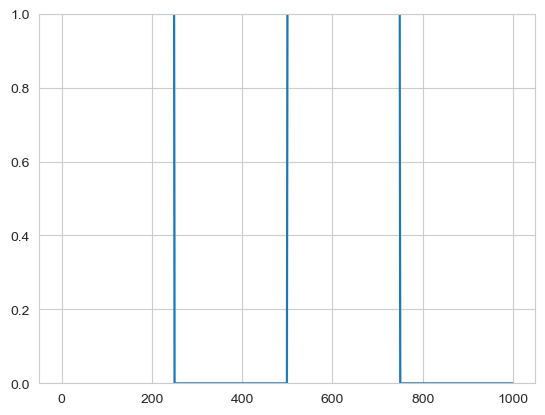

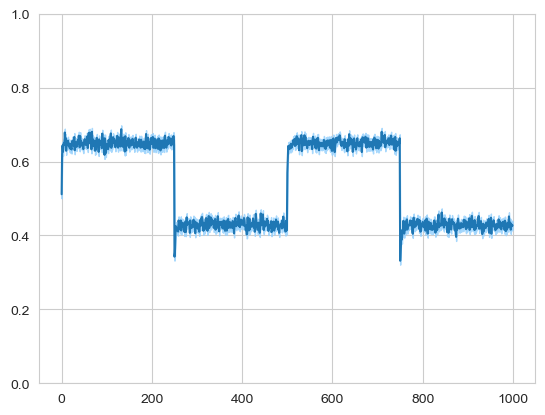

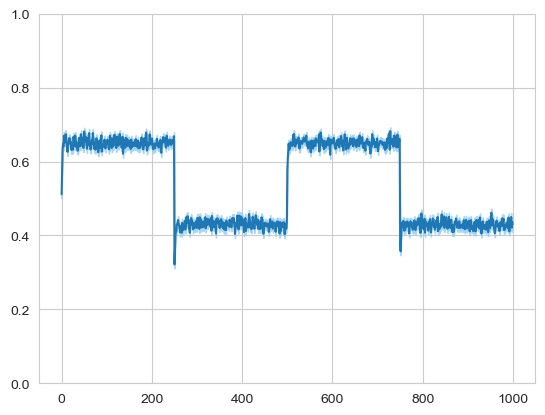

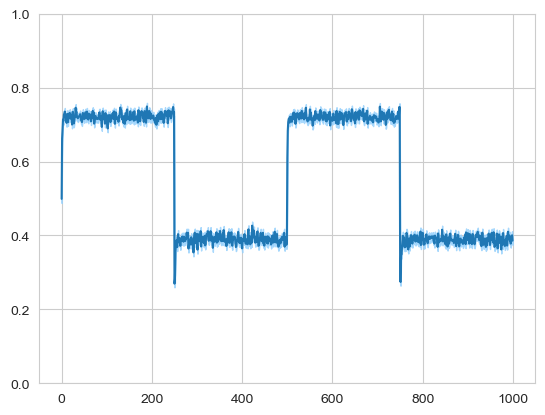

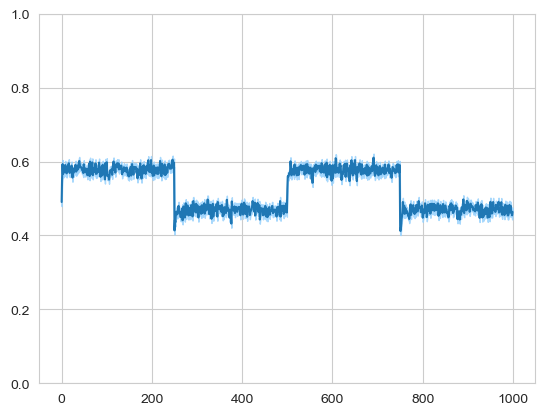

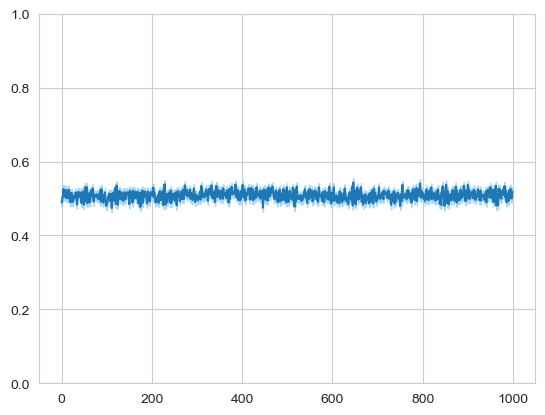

In [4]:
# F.plot_returns(returns_Q)
# F.plot_returns(returns_Q_greedy)
# F.plot_returns(returns_Q_smart)
# F.plot_returns(returns_Q_social)
# F.plot_returns(returns_EWA)
# F.plot_returns(returns_EWA_asoc)

for ret in returns_all:
    F.plot_returns(ret)

### Q-learning

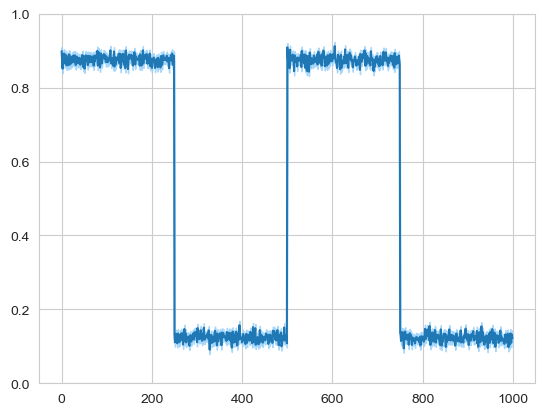

In [4]:
F.plot_returns(returns_Q)

### EWA

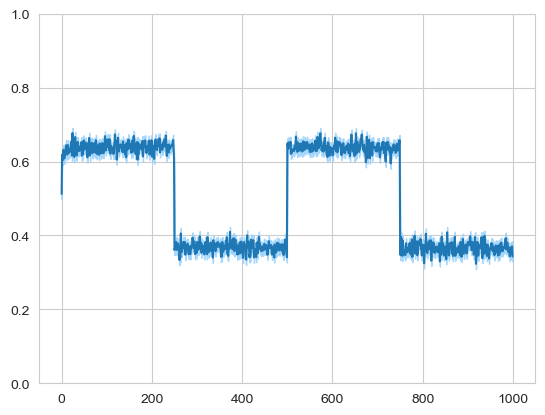

In [5]:
F.plot_returns(returns_EWA)


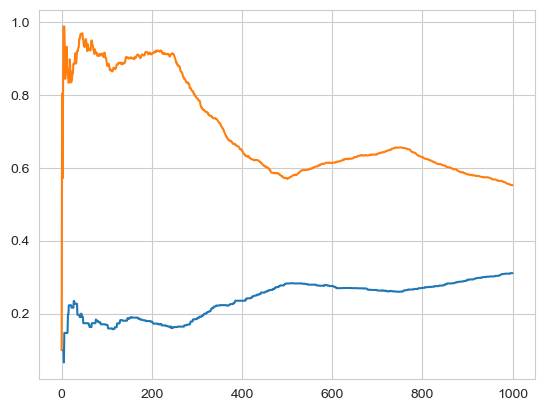

In [5]:
plt.plot(agentQ.Q_vals)

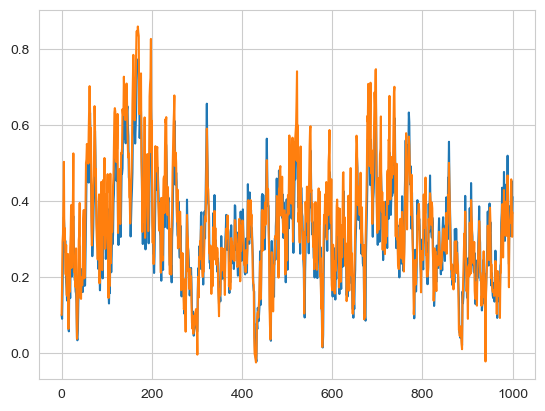

In [6]:
plt.plot(agentEWA.Q_vals)

In [ ]:
print(np.mean(agentEWA1.correct), np.mean(agentQ1.correct) )

0.501 0.476


446.84698492019896 441.1802904727145


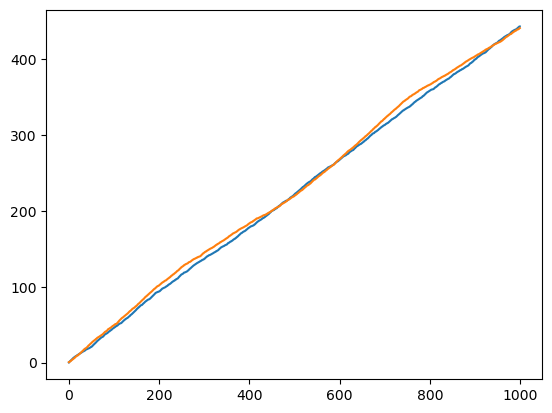

In [ ]:
# plt.plot(np.cumsum(agentEWA1.payoffs))
plt.plot(np.cumsum(agentEWA2.payoffs))
plt.plot(np.cumsum(agentQ1.payoffs))

print(np.sum(agentEWA1.payoffs),np.sum(agentQ1.payoffs))